In [1]:
from io import StringIO
import requests
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_data_1 = pd.read_csv('C:/Users/103467/Python/TimeSeriesAnalysis/DCOILBRENTEU_11Oct.csv')
df_data_1.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [3]:
len(df_data_1)

8709

Data Source
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [4]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(8474, 2)


In [9]:
df_data_1.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


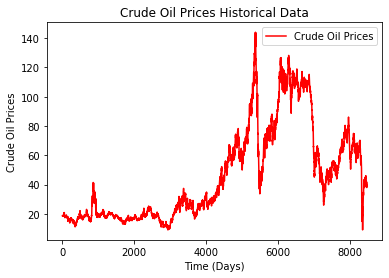

In [5]:
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [13]:
series =  df_data_1.iloc[:,1:2]

In [15]:
series = np.array(series)
series [:5]

array([['18.63'],
       ['18.45'],
       ['18.55'],
       ['18.60'],
       ['18.63']], dtype=object)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [16]:
time = df_data_1.index
split_time = np.ceil(0.9*(len(df_data_1))).astype(int)
print(split_time)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

7627


In [31]:
x_train=x_train.astype(np.float)

In [39]:
x_valid=x_valid.astype(np.float)

In [40]:
test_x=[]
for i in range(len(x_valid)):
    #print(x_train[i][0])
    test_x.append(x_valid[i][0])

In [32]:
train_x=[]
for i in range(len(x_train)):
    #print(x_train[i][0])
    train_x.append(x_train[i][0])

In [33]:
train_x[:5]

[18.63, 18.45, 18.55, 18.6, 18.63]

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(train_x, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
60/60 [==============================] - 1s 10ms/step - loss: 176.5807 - mae: 177.0807 - lr: 1.0000e-08
Epoch 2/100
60/60 [==============================] - 1s 9ms/step - loss: 160.2814 - mae: 160.7814 - lr: 1.1220e-08
Epoch 3/100
60/60 [==============================] - 1s 9ms/step - loss: 138.1004 - mae: 138.6004 - lr: 1.2589e-08
Epoch 4/100
60/60 [==============================] - 1s 9ms/step - loss: 113.1664 - mae: 113.6664 - lr: 1.4125e-08
Epoch 5/100
60/60 [==============================] - 1s 9ms/step - loss: 88.2214 - mae: 88.7214 - lr: 1.5849e-08
Epoch 6/100
60/60 [==============================] - 1s 9ms/step - loss: 61.9086 - mae: 62.4083 - lr: 1.7783e-08
Epoch 7/100
60/60 [==============================] - 1s 9ms/step - loss: 32.8096 - mae: 33.3065 - lr: 1.9953e-08
Epoch 8/100
60/60 [==============================] - 1s 9ms/step - loss: 14.2461 - mae: 14.7431 - lr: 2.2387e-08
Epoch 9/100
60/60 [==============================] - 1s 9ms/step - loss: 4.8801 - mae: 

60/60 [==============================] - 1s 11ms/step - loss: 20.3334 - mae: 20.8266 - lr: 3.5481e-05
Epoch 73/100
60/60 [==============================] - 1s 11ms/step - loss: 28.9191 - mae: 29.4160 - lr: 3.9811e-05
Epoch 74/100
60/60 [==============================] - 1s 11ms/step - loss: 23.8136 - mae: 24.3104 - lr: 4.4668e-05
Epoch 75/100
60/60 [==============================] - 1s 11ms/step - loss: 18.3580 - mae: 18.8504 - lr: 5.0119e-05
Epoch 76/100
60/60 [==============================] - 1s 11ms/step - loss: 19.6917 - mae: 20.1869 - lr: 5.6234e-05825 - mae: 18.97
Epoch 77/100
60/60 [==============================] - 1s 13ms/step - loss: 15.8695 - mae: 16.3617 - lr: 6.3096e-05
Epoch 78/100
60/60 [==============================] - 1s 13ms/step - loss: 17.9221 - mae: 18.4149 - lr: 7.0795e-05490 - mae: 19. - ETA: 0s - loss: 13.4607 - mae: 
Epoch 79/100
60/60 [==============================] - 1s 14ms/step - loss: 26.2565 - mae: 26.7525 - lr: 7.9433e-05
Epoch 80/100
60/60 [=========

[1e-08, 0.0001, 0, 30]

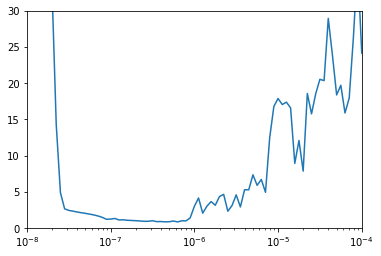

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
val_dataset = windowed_dataset(test_x, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae',
                                                    patience=5,
                                                    mode='min')

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400,callbacks=[early_stopping])

Epoch 1/400
60/60 [==============================] - 1s 10ms/step - loss: 38.4121 - mae: 38.9087
Epoch 2/400
60/60 [==============================] - 1s 10ms/step - loss: 12.8539 - mae: 13.3425
Epoch 3/400
60/60 [==============================] - 1s 10ms/step - loss: 6.9229 - mae: 7.4031
Epoch 4/400
60/60 [==============================] - 1s 9ms/step - loss: 3.7246 - mae: 4.1857
Epoch 5/400
60/60 [==============================] - 1s 11ms/step - loss: 2.2947 - mae: 2.7405
Epoch 6/400
60/60 [==============================] - 1s 13ms/step - loss: 1.7026 - mae: 2.1342
Epoch 7/400
60/60 [==============================] - 1s 13ms/step - loss: 1.6769 - mae: 2.1066: 0s - loss: 1.6738 - mae: 2.0
Epoch 8/400
60/60 [==============================] - 1s 13ms/step - loss: 1.9038 - mae: 2.3327
Epoch 9/400
60/60 [==============================] - 1s 13ms/step - loss: 1.5480 - mae: 1.9832
Epoch 10/400
60/60 [==============================] - 1s 13ms/step - loss: 1.5406 - mae: 1.9627
Epoch 11/400
60/

In [51]:
series = series.astype(np.float)
series

array([[18.63],
       [18.45],
       [18.55],
       ...,
       [39.75],
       [38.  ],
       [39.78]])

In [52]:
series_n =[]
for i in range(len(series)):
    series_n.append(series[i][0])

In [66]:
series_n = np.array(series_n,dtype='float32')

In [67]:
series_n[:5]

array([18.63, 18.45, 18.55, 18.6 , 18.63], dtype=float32)

In [58]:
time=int(time)

In [61]:
window_size=int(window_size)

In [60]:
split_time=int(split_time)

In [68]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series_n[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [69]:
len(forecast)

847

In [72]:
len(test_x)

847

In [73]:
len(time_valid)

847

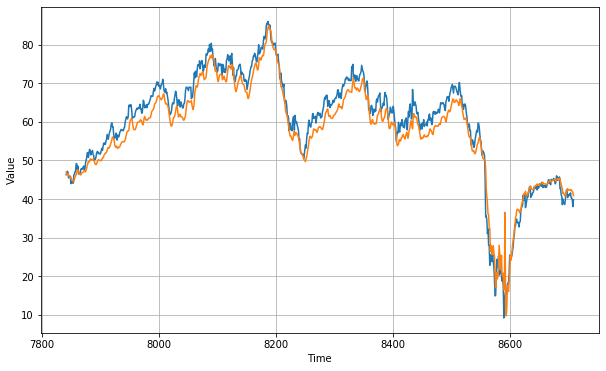

In [71]:
plt.figure(figsize=(10, 6))
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plot_series(time_valid, test_x)
plot_series(time_valid, results)